In [1]:
import pandas as pd 
import numpy as np

import matplotlib as mpl #Used for controlling color import matplotlib.colors #Used for controlling color as well import matplotlib.pyplot as plt import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns;# sns.set()

import scipy.signal as sg 
from scipy.signal import argrelextrema
from scipy import stats

import xarray as xr

import os
import glob

import time 
from math import *

import matplotlib.ticker as mticker

from datetime import datetime,timezone 
import dateutil.tz as tz

from pysolar import solar

import math

from datetime import datetime, timedelta
#from scipy.interpolate import spline
from scipy.stats import kendalltau

#import pymannkendall as mk
from sklearn.metrics import r2_score

from scipy.stats import pearsonr


import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from matplotlib.colors import LogNorm

In [2]:
df_spn = pd.read_csv('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/all/scatterplots/spn1_pyranometer_manilaobservatory_5min_2019.csv')
df_spn['Datetime_LT'] = pd.to_datetime(df_spn['Datetime_LT'])

In [3]:
df_cod = pd.read_csv('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/02_cirrus_stat_figures/2019_cirrus_v2025.csv')
df_cod['Datetime_LT'] = pd.to_datetime(df_cod['Datetime_LT'])#.dt.tz_localize('Asia/Manila')
df_cod['Datetime_UTC'] = df_cod['Datetime_LT'].dt.tz_convert('UTC')
df_cod['LC'] = df_cod['low_cld']
df_cod = df_cod[['year', 'month_LT','day_LT','hour_LT','Datetime_UTC', 'Datetime_LT','LC','od_mean','season','cld_top', 'cld_bot']]
df_cod['cld_tck'] = df_cod['cld_top'] - df_cod['cld_bot']

In [4]:
df_cod.LC.unique()

array(['N', 'Y'], dtype=object)

In [5]:
cod_spn = pd.merge(df_cod,df_spn,on=['Datetime_LT'], how='inner', indicator=True)
cod_spn = cod_spn.replace(0, np.nan)

cod_spn = cod_spn[['Datetime_LT', 'Datetime_UTC', 'season','mon','sza','cos(SZA)','LC','od_mean','cld_top', 'cld_bot','cld_tck','CMP22_Total_Solar',
                   'CM_cor','SPN1_Total_Solar', 'SPN1_Diff_Solar','F_down/cos(SZA)', 
                   'F_down_direct/cos(SZA)', 'F_down_diffuse/cos(SZA)'
                   ]]
cod_spn['day'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.day
cod_spn['mon'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.month

In [6]:
cod_spn['SPN1_Total'] = cod_spn['SPN1_Total_Solar']
cod_spn['SPN1_Diffuse'] = cod_spn['SPN1_Diff_Solar']
cod_spn['Tdir'] = (cod_spn['SPN1_Total']  - cod_spn['SPN1_Diff_Solar']) / cod_spn['SPN1_Total']


In [7]:
cod_spn['SPN1_Total'] = cod_spn['SPN1_Total_Solar']
cod_spn['SPN1_Diffuse'] = cod_spn['SPN1_Diff_Solar']
cod_spn['Tdir'] = (cod_spn['SPN1_Total']  - cod_spn['SPN1_Diff_Solar']) / cod_spn['SPN1_Total']

#updated part based on 02_02_cirrus_stat_allpts
cod_spn.loc[(cod_spn['LC'] == 'N') & (cod_spn['cld_bot']<=4000), 'low_cld'] = 'Y'

cod_spn.loc[cod_spn['LC'] == 'Y', 'od_mean'] = np.nan
cod_spn.loc[cod_spn['LC'] == 'Y', 'cld_top'] = np.nan
cod_spn.loc[cod_spn['LC'] == 'Y', 'cld_bot'] = np.nan

cod_spn['cld_top'] = cod_spn['cld_top']/1000
cod_spn['cld_bot'] = cod_spn['cld_bot']/1000
cod_spn['cld_tck'] = cod_spn['cld_top'] - cod_spn['cld_bot']

In [8]:
cod_spn = cod_spn.drop_duplicates()

In [10]:
#OLD

#we see the cld_bot and cld_tck, then classify as thin or thick
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'] >= 0) & (cod_spn['cld_tck'] >= 0) &
    (cod_spn['od_mean'] > 0) & (cod_spn['od_mean'] <0.3)
    ), 'od_group'] = 'thin'

cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'] >= 0) & (cod_spn['cld_tck'] >= 0) &
    (cod_spn['od_mean'] >= 0.3) & (cod_spn['od_mean'] <1)
    ), 'od_group'] = 'thick'

######################################################################################
#set up for attenuated case
#this is updated to >=1
cod_spn.loc[(
    (cod_spn['LC']=='N') & 
    (cod_spn['od_mean'] >= 1)
    ), 'od_group'] = '>1'


######################################################################################
#clear cases
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'].isnull()) & (cod_spn['cld_top'].isnull()) #&
    #(cod_spn['od_mean'].isnull()) 
    ), 'od_group'] = 'clear'

######################################################################################
cod_spn.loc[(
    (cod_spn['LC'] == 'Y')
    ), 'od_group'] = 'LC'


# Try including another clear-sky test.

In [11]:
#Part 1: Retaining GHI values that passed Test 1 to 3
#sigma_lim = 1.2
diffuse_solar_lim = 150 #Dmax

def flag_clear(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000) \
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            flag_clear = 'Y'
            
        else:
            flag_clear = 'N'

            
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)\
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            flag_clear = 'Y'
            
        else:
            flag_clear = 'N'

    return(flag_clear)

def test_ghi(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000) \
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_ghi = a['SPN1_Total_Solar']
            
        else:
            t1_ghi = np.nan

            
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)\
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_ghi = a['SPN1_Total_Solar']

        else: 
            t1_ghi = np.nan

    return(t1_ghi)

#Part 2: Retaining DHI Values that passed Test 1 & 2
def test_dhi(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000)
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_dhi = a['SPN1_Diff_Solar']  
            
        else:
            t1_dhi = np.nan
                     
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_dhi = a['SPN1_Diff_Solar'] 
            
        else: 
            t1_dhi = np.nan
           
    return(t1_dhi)


#Part 4: (for Plotting) Imposed Limits for Test 1
def lim(a):
    if (a['sza'] < 78.5):
        lim = 1000
    elif (a['sza'] >= 78.5):
        lim = 900
    return(lim)

In [12]:
a = cod_spn
a['dhi'] = a['SPN1_Diffuse']
a['ghi_a'] = a['SPN1_Total']


# Calculate the clear sky estimates of GHI, DNI, and/or DHI at this location
# Ineichen-Perez Clear Sky model 
tus = Location(14.6361, 121.0775, 'Asia/Manila', 100, 'Manila')
times = pd.date_range(start='2019-07-01', end='2020-12-31', freq='5min', tz=tus.tz)

#https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html
cs = tus.get_clearsky(times).reset_index()
cs['Datetime_UTC'] = pd.to_datetime(cs['index']).dt.tz_convert('utc')

#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html#pvlib.solarposition.get_solarposition
cs2 = tus.get_solarposition(times).reset_index()
cs2['Datetime_UTC'] = pd.to_datetime(cs2['index']).dt.tz_convert('utc')

cs2['sza'] = cs2['apparent_zenith']
cs = cs.merge(cs2, how='inner', on='Datetime_UTC')
cs = cs[[ 'Datetime_UTC', 'ghi', 'dni', 'dhi']]

In [13]:
cs['GHI_in'] = cs['ghi']
cs['DNI_in'] = cs['dni']
cs['DHI_in'] = cs['dhi']
cs = cs[['Datetime_UTC', 'GHI_in', 'DNI_in', 'DHI_in']]

a = a.merge(cs, how='inner', on='Datetime_UTC')

#Calculate Cosine of Solar Zenith Angle
#a["cossza"] = a.apply(cossza, axis=1)
#Calculate Direct Normal Irradiance
a["dni"] = a['Tdir']

#Remove timesteps when solar zenith angle is greater than 90 (nighttime values)
a = a[a['sza']<= 90]

a = a[['Datetime_UTC', 'Datetime_LT', 'SPN1_Total_Solar', 'SPN1_Diff_Solar', \
       'dhi', 'ghi_a', 'sza', 'cos(SZA)', 'dni']]

#Prepare Local Time for plots & clear sky calculation
a['LST'] = a['Datetime_LT']

a = a.set_index('LST')

a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute

In [14]:
#Remove timesteps when solar zenith angle is greater than 90 (nighttime values)
a = a[a['sza']<= 90]

a = a[['Datetime_UTC', 'Datetime_LT', 'SPN1_Total_Solar', 'SPN1_Diff_Solar',\
       'dhi', 'ghi_a', 'sza', 'cos(SZA)', 'dni']]

#Prepare Local Time for plots & clear sky calculation
a['LST'] = a['Datetime_LT']

a = a.set_index('LST')

a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute

In [15]:
#Clear Sky Test 1: Normalized Total Shortwave Magnitude Test (Long and Ackerman 2000)
#Equation 1
a["cossza_b"] = (a['cos(SZA)'])**1.31
#Normalized Total Shortwave
a['SPN1_Total_Solar_N'] = a['SPN1_Total_Solar']/a["cossza_b"]

#Clear Sky Test 2: Diffuse Shortwave Magnitude Test (Long and Ackerman 2000)
#Equation 2
a['t2_lim'] = diffuse_solar_lim*((a['cos(SZA)'])**0.5)


#Clear Sky Test 1 - 2: 
#Normalized Total Shortwave Magnitude Test 
#Max Diffuse Shortwave Test
#retains clear-sky periods only
#for plotting
a['ghi_cc_val'] = a.apply(test_ghi, axis=1)
a['dhi_cc_val'] = a.apply(test_dhi, axis=1)
a['t1_lim'] = a.apply(lim, axis=1)
a['flag_clear'] = a.apply(flag_clear, axis=1)

# Update my clear cases from HSRL to incorporate SPN-based clear conditions.

In [16]:
a = a[['Datetime_LT', 'flag_clear']]
cod_spn = pd.merge(cod_spn,a,on=['Datetime_LT'], how='inner', indicator=True)

In [17]:
#clear cases
cod_spn.loc[(
    (cod_spn['od_group'] == 'clear') &
    (cod_spn['flag_clear'] == 'N') 
    ), 'od_group'] = 'clear_no'

In [18]:
cod_spn['day_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.day
cod_spn['month_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.month
cod_spn['year_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.year
fin = cod_spn

fin['mon_day_yr'] = fin['month_LT'].astype(str) + '-' + fin['day_LT'].astype(str) + '-' + fin['year_LT'].astype(str)

In [19]:
fin['SPN1_Direct'] = fin['SPN1_Total'] - fin['SPN1_Diffuse']
fin['ghi_spn1'] = fin['F_down_direct/cos(SZA)'] + fin['SPN1_Diffuse']

fin['f_diff'] = fin['SPN1_Diffuse'] / fin['SPN1_Total']
fin = fin[(fin['f_diff'] <= 1) & (fin['f_diff'] >= 0)]


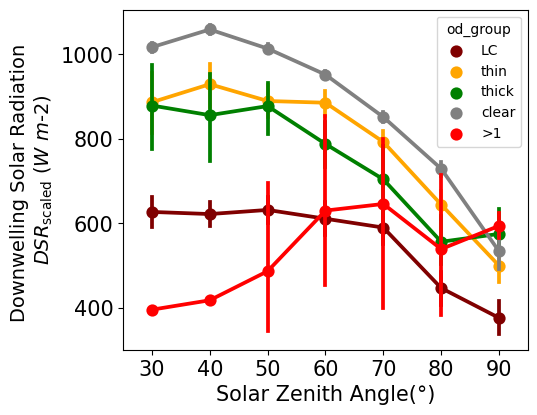

In [20]:
color_dict = dict({ 'clear': "#808080",
          'thin': "#FFA500",
          'thick': "#008000",
          '>1' : "#FF0000",  
          'LC' : "#800000"
                  })

order=["clear", "thin", "thick", ">1", "LC"]


#make complete plots
a4_dims = (6,5)
fig = plt.figure(figsize=a4_dims)
gs = fig.add_gridspec(1, 1,wspace=0.5,hspace=0.35)

################################################
mfin = fin
mfin = mfin[mfin['od_group']!="clear_no"]
mfin = mfin[mfin['od_group']!="atten"]

mfin['gt'] = np.nan
mfin.loc[((mfin['sza'] >= 20) & (mfin['sza']< 30)), 'gt'] = 30
mfin.loc[((mfin['sza'] >= 30) & (mfin['sza'] < 40)), 'gt'] = 40
mfin.loc[((mfin['sza'] >= 40) & (mfin['sza'] < 50)), 'gt'] = 50
mfin.loc[((mfin['sza'] >= 50) & (mfin['sza'] < 60)), 'gt'] = 60
mfin.loc[((mfin['sza'] >= 60) & (mfin['sza'] < 70)), 'gt'] = 70
mfin.loc[((mfin['sza'] >= 70) & (mfin['sza'] < 80)), 'gt'] = 80
mfin.loc[((mfin['sza'] >= 80) & (mfin['sza'] < 90)), 'gt'] = 90
mfin3 = mfin[mfin['od_mean'] < 0.3]
mfin4 = mfin[mfin['od_mean'] >= 0.3]
################################################
ax = fig.add_subplot(gs[0, 0])
with plt.rc_context({'lines.linewidth': 1.5}):
    sns.pointplot(x="gt", y="F_down/cos(SZA)",  hue="od_group",palette=color_dict, data=mfin,  estimator=np.mean)

plt.ylabel('Downwelling Solar Radiation \n$DSR_{\mathrm{scaled}}$ ($W$ $m$-2)', fontsize=14)
plt.xlabel('Solar Zenith Angle(°)', fontsize=15, fontweight='regular')
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15) 
ax.set_xticks([0, 1,2,3,4,5,6 ])
ax.set_xticklabels([ '30', '40', '50', '60', '70', '80', '90'])

plt.gcf().subplots_adjust(bottom=0.2, right=0.8)
output_filename = f'fig7_cirruspbl.png'
plt.savefig(output_filename, dpi= 300, bbox_inches="tight")